# "Pump it Up: Data Mining the Water Table"

EDA

Jason & Tom

In [31]:
# Imports

import pandas as pd
import numpy as np

# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Chi Square
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Test Train Split
from sklearn.model_selection import train_test_split

# Models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb

# Model Selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

# Balancing the dataset.
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import joblib

# EDA

This notebook explains the steps we took while performing EDA on our cleaned dataset. Whilst EDA does technically include 'data cleaning', we took the initiative to place that in it's own notebook so that the steps we took are much clearer. This notebook will present our findings on the correlation between certain features, as well as feature selection / engineering.

We both took different steps to do this, and collated our findings at the end. Cells by one author only will contain ``` Written By [Author] ``` at the top. Cells without this tag were steps taken by both of us, unless specified.

In [2]:
df = pd.read_csv("./datasets/cleaned_water.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)

# 1 Feature Engineering

In [3]:
# From here: https://github.com/BrendaLoznik/waterpumps

df['recorded_year'] = pd.DatetimeIndex(df ['date_recorded']).year
df['age'] = df['recorded_year'] - df['construction_year']
df['age'] = df['age'].apply(lambda x: x if x < 100 else -1)
df = df.drop('recorded_year',axis=1)

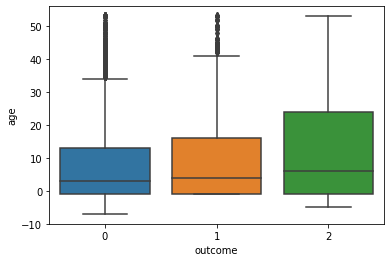

In [4]:
sns.boxplot(x='outcome', y='age', data=df)
plt.show()

In [4]:
# From here: https://github.com/BrendaLoznik/waterpumps

df['month'] = pd.DatetimeIndex(df['date_recorded']).month

# season encoder
# 1: 'short dry', 2: 'long rain', 3: 'long dry', 4: 'short rain'
season_mapper = {1: 1,2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3,
                 8: 3, 9: 3, 10: 3, 11: 4, 12: 4}
#.p feature values to scale
df['season']=df['month'].replace(season_mapper)
df=df.drop('month', axis=1)

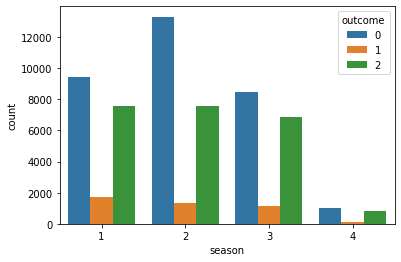

In [6]:
sns.countplot(x='season', hue='outcome', data=df)
plt.show()

In [5]:
# Author [Tom]

# quantity = 1 (enough) se to 1, everything else set to 0
df['consistent_water'] = np.where(df['quantity'] == 1, 1, 0)

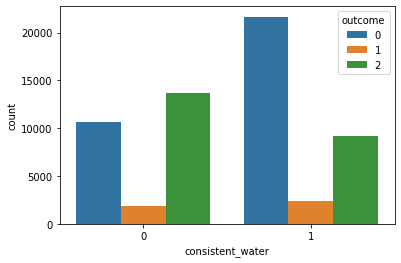

In [8]:
sns.countplot(x='consistent_water', hue='outcome', data=df)
plt.show()

In [6]:
# Author [Tom]

df['source_below_sea_level'] = np.where(df['gps_height'] < df['amount_tsh'], 1, 0)

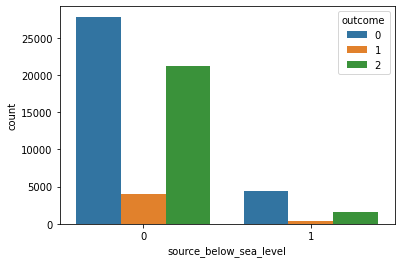

In [10]:
sns.countplot(x='source_below_sea_level', hue='outcome', data=df)
plt.show()

In [11]:
df.to_csv('./datasets/water_fe.csv')

# 2 Graphing

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 58 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           59400 non-null  int64  
 1   amount_tsh                   59400 non-null  float64
 2   date_recorded                59400 non-null  object 
 3   funder                       55765 non-null  object 
 4   gps_height                   59400 non-null  int64  
 5   installer                    55745 non-null  object 
 6   longitude                    59400 non-null  float64
 7   latitude                     59400 non-null  float64
 8   wpt_name                     59400 non-null  object 
 9   num_private                  59400 non-null  int64  
 10  basin                        59400 non-null  int64  
 11  subvillage                   59029 non-null  object 
 12  region                       59400 non-null  object 
 13  region_code     

## 2.1 Correlation Matrix

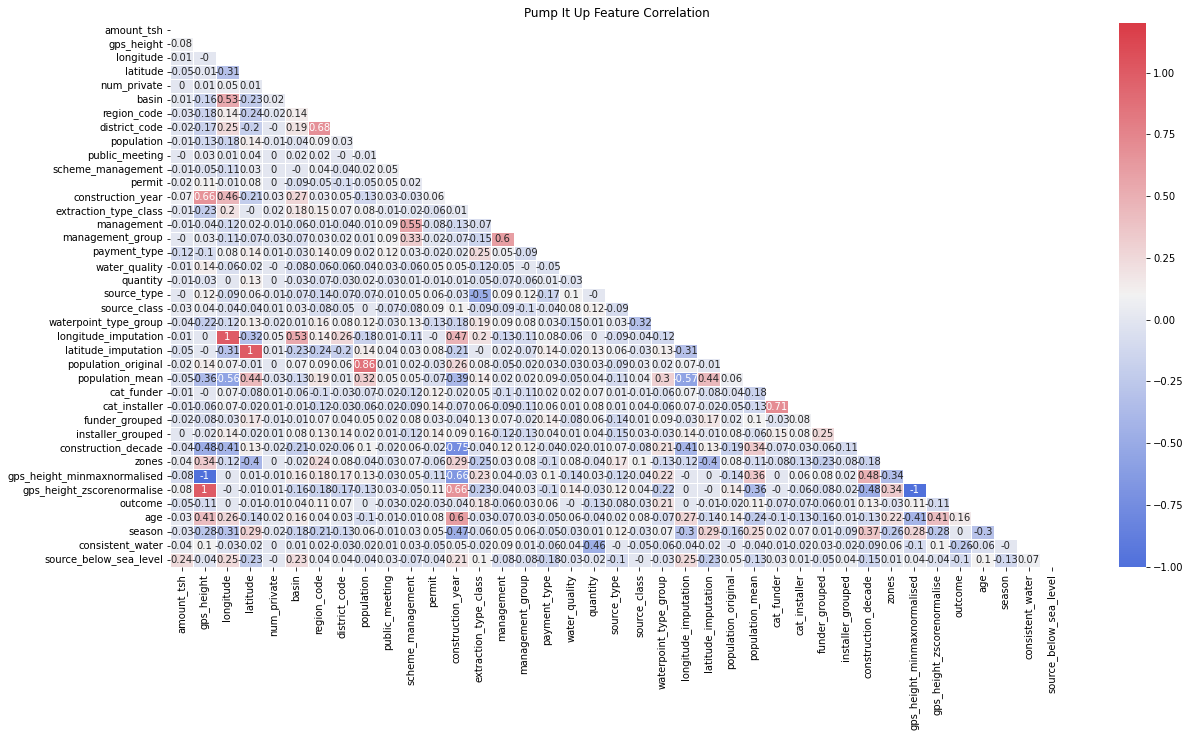

In [9]:
# Author [Jason]
# Code adapted from COMP 3009 Lab Sheet

feature = df.drop(columns=['id'])

corrMatt = feature.corr().round(2)

# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 10))
plt.title('Pump It Up Feature Correlation')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask,
ax=ax, annot=True, fmt='.2g', linewidths=1);

There's not many super highly correlated features.

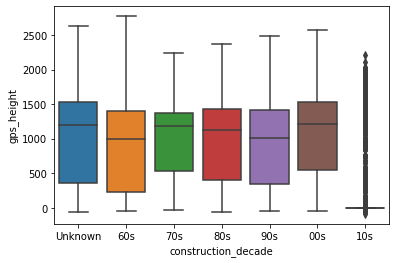

In [14]:
ax = sns.boxplot(data=df, x='construction_decade', y='gps_height')
ax.set_xticklabels(['Unknown', '60s', '70s', '80s', '90s', '00s', '10s'])
plt.show()

There doesn't seem to be a significant change in decade and gps_height.
Add more to here if we want to test out any other correlations between features.

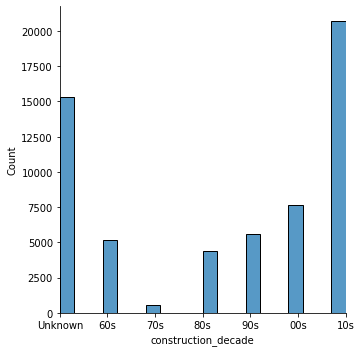

In [15]:
ax = sns.displot(data=df, x='construction_decade')
plt.xlim(0,6)
ax.set_xticklabels(['Unknown', '60s', '70s', '80s', '90s', '00s', '10s'])
plt.show()

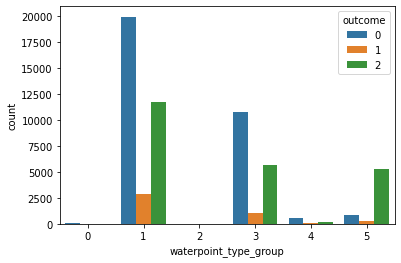

In [16]:
sns.countplot(x='waterpoint_type_group', hue='outcome', data=df)
plt.show()

Here, we can see that waterpoint_type_group 5 has a lot more of category 2, although this could be due to limited data.

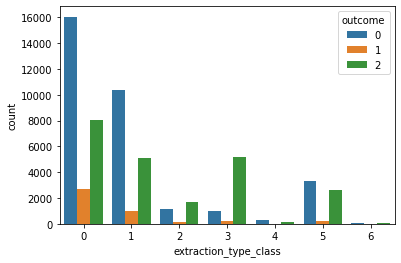

In [17]:
sns.countplot(x='extraction_type_class', hue='outcome', data=df)
plt.show()

Again, we can see that certain classes of extraction types are more likely to be of category 2.

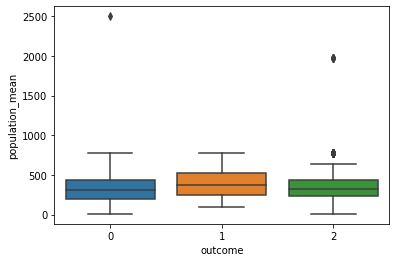

In [18]:
sns.boxplot(x='outcome', y='population_mean', data=df)
plt.show()

It's not crazy significant, but faulty wells usually have a larger population.

# 3 Feature Importance

## 3.1 Random Forest

In [10]:
classification_target = df['outcome']

clean_feature = feature.drop(columns = ['date_recorded', 'wpt_name','num_private','subvillage','region_code','district_code','lga','ward','recorded_by',
                            'scheme_name','extraction_type','extraction_type_group','payment','quality_group','quantity_group',
                            'source','waterpoint_type','status_group','construction_year','region','funder','installer', 'outcome'])

In [11]:
# Author [Jason]
X_train, X_test, y_train, y_test = train_test_split(clean_feature,classification_target, test_size=0.2, random_state=42, stratify=classification_target)
rf = RandomForestClassifier(n_estimators=120,class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=120)

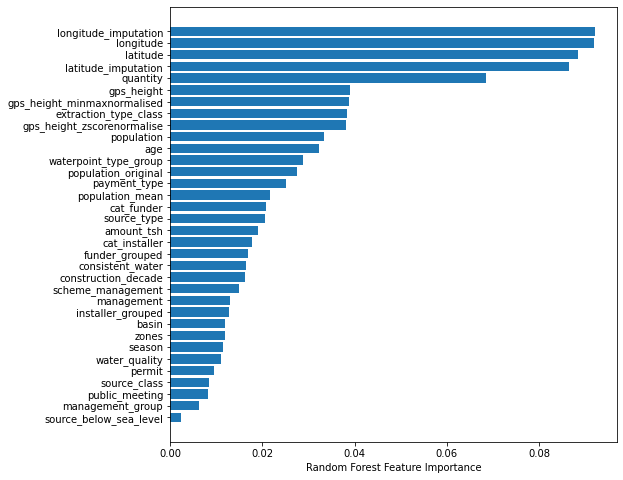

In [12]:
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(8,8))
plt.barh(clean_feature.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

## Chi Square Tests

In [13]:
categorical_features = clean_feature[['basin','public_meeting','scheme_management','permit','extraction_type_class','management','management_group','payment_type','water_quality','quantity','source_type',
                                     'source_class','waterpoint_type_group','cat_funder','cat_installer','funder_grouped','installer_grouped','construction_decade','zones','season','consistent_water','source_below_sea_level']]

In [14]:
# Author [Jason]

# Select the top 10 best categorical features
categorical_features = SelectKBest(chi2, k=10).fit(categorical_features, classification_target)

# Convert the selected clinical feature's header name into a list
categorical_features_list = list(categorical_features.get_feature_names_out())
print(categorical_features_list)

['extraction_type_class', 'payment_type', 'quantity', 'source_type', 'source_class', 'waterpoint_type_group', 'cat_funder', 'construction_decade', 'consistent_water', 'source_below_sea_level']


## Feature Dropping

Based on Chi Square Test, we know that the 10 best out of the 22 categorical variables are:
    
    - 'extraction_type_class', 'payment_type', 'quantity', 'source_type', 'source_class', 'waterpoint_type_group', 'cat_funder', 'construction_decade', 'consistent_water', 'source_below_sea_level'

This is kind of similar to the results from the random forest, however, we would also like to include: `age`, `season`, `water_quality`, `cat_installer` & `water_quality`, whilst dropping `source_below_sea_level`.

We can still test this during the modelling phase, and different combinations of features will be tested in order to improve metrics.


In terms of continous variables, we know that `gps_height_*normalized` has a high negative correlation to the target variable from the correlation matrix so we will test which version of normalization has a higher accuracy score.

In [26]:
# This is not the final feature selection, it is just the first iteration of the process.

features = clean_feature[['extraction_type_class', 'payment_type', 'quantity', 'source_type',
                         'waterpoint_type_group', 'cat_funder', 'construction_decade', 'consistent_water',
                         'age', 'season', 'water_quality', 'cat_installer', 'gps_height_zcorenormalise',
                         'longitude_imputation', 'latitude_imputation', 'population']]
target = df['outcome']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

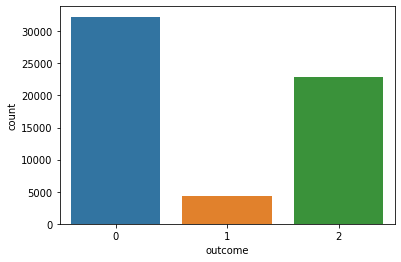

In [28]:
sns.countplot(x='outcome', data=df)
plt.show()

Imbalanced dataset unfortunately, we will have to deal with this.

# Modelling

### LinearSVC

In [27]:
clf_svc = LinearSVC(dual=False, class_weight='balanced', random_state=42)

scores = cross_val_score(clf_svc, X_train, y_train, cv=5)

In [28]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.66 accuracy with a standard deviation of 0.00


### HistGradientBoost

In [29]:
clf_hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_val_score(clf_hgb, X_train, y_train, cv=5)

In [30]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.79 accuracy with a standard deviation of 0.00


Accuracy: 0.7867845117845118
Precision: 0.7867845117845118
Recall: 0.7867845117845118


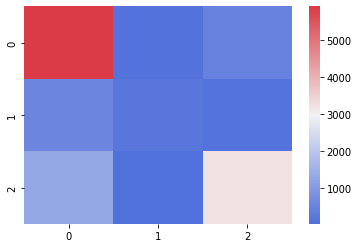

In [31]:
clf_hgb.fit(X_train, y_train)
preds = clf_hgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))
print("Precision:", precision_score(y_test, preds, average='micro'))
print("Recall:", recall_score(y_test, preds, average='micro'))
cmap = sns.diverging_palette(260, 10, as_cmap=True)
sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap)
plt.show()

Yeh, as we can see here, it's really good at 0 <-> 0, decent at 2 <-> 2, but terrible at 1 <-> 1. Definitely needs to be balanced. When the actual class is 1, it's more likely to be predicted as 0.

The row is y_true, the column is y_pred

### XGBoost

In [40]:
dtrain = xgb.DMatrix(X_train, label=y_train)
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'merror',
    'seed': 0
}
clf_xgb = xgb.XGBClassifier(**params)
scores = cross_val_score(clf_xgb, X_train, y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.79 accuracy with a standard deviation of 0.00


Accuracy: 0.79006734006734
Precision: 0.7519246111682053
Recall: 0.6241065778053657


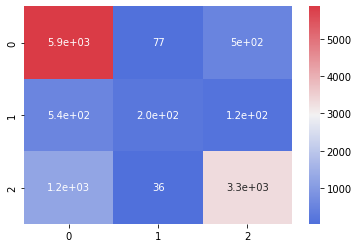

In [41]:
clf_xgb = xgb.XGBClassifier(**params)
clf_xgb.fit(X_train, y_train)
preds = clf_xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))
print("Precision:", precision_score(y_test, preds, average='macro'))
print("Recall:", recall_score(y_test, preds, average='macro'))
cmap = sns.diverging_palette(260, 10, as_cmap=True)
sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap, annot=True)
plt.show()

## Balancing The Dataset

As we can see from the previous tests in model building, the fact that the dataset is unbalanced means we really struggle to accurately predict the 1 <-> 1 class. We can try to balance this using SMOTE-ENN.

In [18]:
sm = SMOTE(random_state=42, k_neighbors=2, sampling_strategy='minority')
enn = EditedNearestNeighbours(sampling_strategy=[1])

In [19]:
sme = SMOTEENN(random_state=42, smote=sm, enn=enn)
X_res, y_res = sme.fit_resample(X_train, y_train)

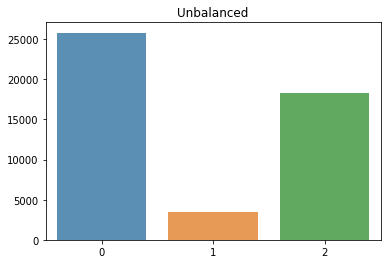

In [20]:
y_train_count = y_train.value_counts()
sns.barplot(x=y_train_count.index, y=y_train_count.values, alpha=0.8)
plt.title("Unbalanced")
plt.show()

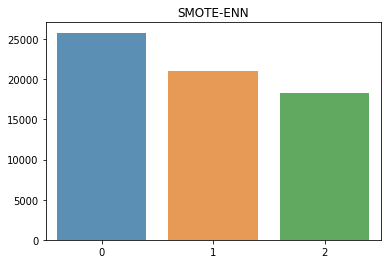

In [21]:
y_res_count = y_res.value_counts()
sns.barplot(x=y_res_count.index, y=y_res_count.values, alpha=0.8)
plt.title("SMOTE-ENN")
plt.show()

Accuracy: 0.7762626262626262
Precision: 0.6663658442576952
Recall: 0.6305333793933316


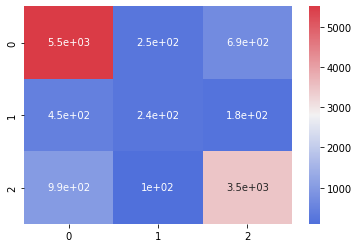

In [29]:
# These params are from the section Hyper-parameter Search - see below.

params = {'subsample': 0.8, 'reg_lambda': 1e-05,
          'reg_alpha': 1, 'n_estimators': 200,
          'min_child_weight': 1, 'max_depth': 9,
          'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}

clf_xgb = xgb.XGBClassifier(**params)
clf_xgb.fit(X_res, y_res)
preds = clf_xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))
print("Precision:", precision_score(y_test, preds, average='macro'))
print("Recall:", recall_score(y_test, preds, average='macro'))
cmap = sns.diverging_palette(260, 10, as_cmap=True)
sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap, annot=True)
plt.show()

## Hyper-parameter Searching

(Tom)

I will be performing hyper-parameter tuning on the balanced dataset to see if we can see any improvements.

Let's try with RandomizedSearch

In [33]:
hps = {
        'max_depth': [3, 6, 9],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 1e-5, 1e-3, 1e-1, 1,1e2],
        'reg_lambda': [0, 1e-5, 1e-3, 1e-1, 1, 1e2],
        'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.3],
        'n_estimators': [50, 100, 150, 200],
        'min_child_weight': [0, 0.2, 0.4, 0.6, 0.8, 1],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.5, 0.7, 0.9, 1],
}

In [34]:
random_cv = RandomizedSearchCV(estimator=clf_xgb,
                              param_distributions=hps,
                              cv=5, n_iter=50,
                              scoring='recall_macro',
                              verbose=5,
                              return_train_score=True,
                              random_state=42)

In [36]:
random_cv.fit(X_res, y_res)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=0.6, n_estimators=100, reg_alpha=100.0, reg_lambda=1e-05, subsample=0.8;, score=(train=0.743, test=0.698) total time=   9.2s
[CV 2/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=0.6, n_estimators=100, reg_alpha=100.0, reg_lambda=1e-05, subsample=0.8;, score=(train=0.733, test=0.740) total time=   8.9s
[CV 3/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=0.6, n_estimators=100, reg_alpha=100.0, reg_lambda=1e-05, subsample=0.8;, score=(train=0.729, test=0.738) total time=  10.1s
[CV 4/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=0.6, n_estimators=100, reg_alpha=100.0, reg_lambda=1e-05, subsample=0.8;, score=(train=0.731, test=0.734) total time=   8.4s
[CV 5/5] END colsample_bytree=0.7, gamma=0.1, learning_rat

[CV 4/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=0.8, n_estimators=150, reg_alpha=1e-05, reg_lambda=100.0, subsample=0.8;, score=(train=0.742, test=0.740) total time=  12.5s
[CV 5/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=0.8, n_estimators=150, reg_alpha=1e-05, reg_lambda=100.0, subsample=0.8;, score=(train=0.742, test=0.738) total time=  12.9s
[CV 1/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=0.4, n_estimators=200, reg_alpha=0.001, reg_lambda=1, subsample=1;, score=(train=0.832, test=0.756) total time=  19.1s
[CV 2/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=0.4, n_estimators=200, reg_alpha=0.001, reg_lambda=1, subsample=1;, score=(train=0.823, test=0.802) total time=  19.8s
[CV 3/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=0.4, n_estimators=200, reg_alpha=0.

[CV 3/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=9, min_child_weight=0, n_estimators=200, reg_alpha=0.1, reg_lambda=0.001, subsample=1;, score=(train=0.870, test=0.829) total time=  44.8s
[CV 4/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=9, min_child_weight=0, n_estimators=200, reg_alpha=0.1, reg_lambda=0.001, subsample=1;, score=(train=0.875, test=0.829) total time=  45.8s
[CV 5/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=9, min_child_weight=0, n_estimators=200, reg_alpha=0.1, reg_lambda=0.001, subsample=1;, score=(train=0.875, test=0.827) total time=  48.3s
[CV 1/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=0.2, n_estimators=150, reg_alpha=1, reg_lambda=100.0, subsample=1;, score=(train=0.808, test=0.745) total time=  19.9s
[CV 2/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=0.2, n_estimators=150, reg_alpha=1, reg_lambda=100

[CV 2/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=150, reg_alpha=0.001, reg_lambda=1e-05, subsample=1;, score=(train=0.771, test=0.765) total time=  20.1s
[CV 3/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=150, reg_alpha=0.001, reg_lambda=1e-05, subsample=1;, score=(train=0.768, test=0.766) total time=  20.6s
[CV 4/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=150, reg_alpha=0.001, reg_lambda=1e-05, subsample=1;, score=(train=0.769, test=0.764) total time=  20.4s
[CV 5/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=150, reg_alpha=0.001, reg_lambda=1e-05, subsample=1;, score=(train=0.770, test=0.760) total time=  22.7s
[CV 1/5] END colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=9, min_child_weight=0.8, n_estimators=150, reg_alpha=0.001, r

[CV 1/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=0.2, n_estimators=100, reg_alpha=1e-05, reg_lambda=1, subsample=1;, score=(train=0.679, test=0.643) total time=   6.0s
[CV 2/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=0.2, n_estimators=100, reg_alpha=1e-05, reg_lambda=1, subsample=1;, score=(train=0.669, test=0.681) total time=   5.9s
[CV 3/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=0.2, n_estimators=100, reg_alpha=1e-05, reg_lambda=1, subsample=1;, score=(train=0.671, test=0.677) total time=   6.1s
[CV 4/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=0.2, n_estimators=100, reg_alpha=1e-05, reg_lambda=1, subsample=1;, score=(train=0.670, test=0.673) total time=   5.8s
[CV 5/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=0.2, n_estimators=100, reg_alpha=1e-05, reg_

[CV 5/5] END colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=0.6, n_estimators=200, reg_alpha=1e-05, reg_lambda=0.001, subsample=0.8;, score=(train=0.910, test=0.840) total time=  29.3s
[CV 1/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=0, n_estimators=50, reg_alpha=0, reg_lambda=1e-05, subsample=1;, score=(train=0.778, test=0.726) total time=   6.3s
[CV 2/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=0, n_estimators=50, reg_alpha=0, reg_lambda=1e-05, subsample=1;, score=(train=0.768, test=0.762) total time=   6.2s
[CV 3/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=0, n_estimators=50, reg_alpha=0, reg_lambda=1e-05, subsample=1;, score=(train=0.767, test=0.767) total time=   6.5s
[CV 4/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=6, min_child_weight=0, n_estimators=50, reg_alpha=0, reg_lambda=1e-05, s

[CV 4/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=0.4, n_estimators=150, reg_alpha=0.1, reg_lambda=0, subsample=0.8;, score=(train=0.741, test=0.742) total time=   7.7s
[CV 5/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=0.4, n_estimators=150, reg_alpha=0.1, reg_lambda=0, subsample=0.8;, score=(train=0.743, test=0.742) total time=  10.7s
[CV 1/5] END colsample_bytree=1, gamma=0, learning_rate=0.2, max_depth=9, min_child_weight=0.2, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=1;, score=(train=0.959, test=0.803) total time=  44.2s
[CV 2/5] END colsample_bytree=1, gamma=0, learning_rate=0.2, max_depth=9, min_child_weight=0.2, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=1;, score=(train=0.953, test=0.858) total time=  46.6s
[CV 3/5] END colsample_bytree=1, gamma=0, learning_rate=0.2, max_depth=9, min_child_weight=0.2, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=1;, score

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.3, max_bin=256,
                                           max_cat_...
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.9, 1],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.3],
                                        'max_depth': [3, 6, 9],
                                        'min_child_weight': [0, 0.2, 0.4, 0.6,
                                                             0.8, 1],
                                        'n_estimators': [50, 100, 150, 200],
                                        'reg_alpha': [0, 1e-05, 0.001, 0.1, 1,
                                                      100.0],
                                        'reg_lambda': [0, 1e-05, 0.001, 0.1, 1,
                                                       100.0],
                                        'subsample': [0.8, 1]},
                   random_state=42, return_train_score=True,
                   scoring='recall_macro', verbose=5)

In [37]:
print("Best Params:", random_cv.best_params_)
print("Best Estiamtor:", random_cv.best_estimator_)
print("Best Score:", random_cv.best_score_)

Best Params: {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}
Best Estiamtor: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=1, ...)
Best Score: 0.8551267090436561


In [38]:
preds = random_cv.best_estimator_.predict(X_test)

Accuracy: 0.7762626262626262
Precision: 0.6663658442576952
Recall: 0.6305333793933316


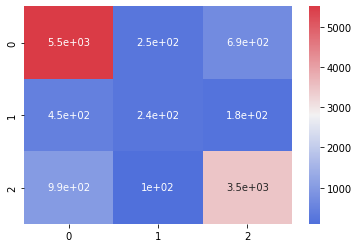

In [39]:
print("Accuracy:", accuracy_score(y_test, preds))
print("Precision:", precision_score(y_test, preds, average='macro'))
print("Recall:", recall_score(y_test, preds, average='macro'))
cmap = sns.diverging_palette(260, 10, as_cmap=True)
sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap, annot=True)
plt.show()

**Best Params for XGBoost on the SMOTEENN dataset**

Best Params: {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}

Best Score: 0.8551267090436561

### Saving the model

In [44]:
import pickle

In [45]:
with open("./models/XGB.pickle", "wb") as f:
    pickle.dump(random_cv.best_estimator_, f)